The code below assumes that you have the images in this directory. to download images you can use the link shared. https://drive.google.com/drive/folders/1vz8jXuCJC8SBMewpA6BQybaS-GrDIeAI?usp=drive_link

## **<font color="#A41034">Setup Notebook</font>**

#### **Configuration**

In [1]:
## Global configuration settings to faciliate Colab and VM training
RUN_IN_VM = False
GET_IMAGES_FROM_GDRIVE = True
GET_IMAGES_FROM_GCSBUCKET_LEC8 = False
GET_IMAGES_FROM_GCSBUCKET_PROJ = False
USE_MOBILENET_AS_TEACHER = False
USE_VGG16_AS_TEACHER = True

#### **Installs**

In [2]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00


#### **Imports**

In [3]:
import argparse
import os
import requests
import zipfile
import tarfile
import time
import json
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# fixer related
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Flatten, Dense
import scipy

# sklearn
from sklearn.model_selection import train_test_split

# Tensorflow Hub
import tensorflow_hub as hub

# W&B
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger



#### **Argument Parser**

In [4]:
# Setup the arguments for the trainer task

if RUN_IN_VM:
  parser = argparse.ArgumentParser()
  parser.add_argument(
      "--model-dir", dest="model_dir", default="test", type=str, help="Model dir."
  )
  parser.add_argument("--lr", dest="lr", default=0.001, type=float, help="Learning rate.")
  parser.add_argument(
      "--model_name",
      dest="model_name",
      default="mobilenetv2",
      type=str,
      help="Model name",
  )
  parser.add_argument(
      "--train_base",
      dest="train_base",
      default=False,
      action="store_true",
      help="Train base or not",
  )
  parser.add_argument(
      "--epochs", dest="epochs", default=10, type=int, help="Number of epochs."
  )
  parser.add_argument(
      "--batch_size", dest="batch_size", default=16, type=int, help="Size of a batch."
  )
  parser.add_argument(
      "--wandb_key", dest="wandb_key", default="16", type=str, help="WandB API Key"
  )
  args = parser.parse_args()


#### **Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [5]:
# TF Version
print("tensorflow version", tf.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())
# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices("GPU"))

print("GPU Available: ", tf.config.list_physical_devices("GPU"))
print("All Physical Devices", tf.config.list_physical_devices())



tensorflow version 2.12.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
GPU Available:  []
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


#### **Utils**

Here are some util functions that we will be using for this notebook
* progressbar()
* get_model_size()
* JsonEncoder
* save_model()
* evaluate_model()

In [6]:
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress

    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.

    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::

        for i in range(n_iterations):
            progressbar(i, n_iterations)

    .. source:

        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """

    import sys                                                     ## import this library to stdio

    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

In [7]:
def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".hdf5")).st_size
  return model_size


In [8]:
class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

In [9]:
experiment_name = "models"
def save_model(model,model_train_history,execution_time, learning_rate, epochs, optimizer, evaluation_results):
  model_name=model.name

  # Ensure path exists
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)
  # Save the enitire model (structure + weights)
  model.save(os.path.join(experiment_name,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(experiment_name,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

  model_size = get_model_size(model_name=model.name)

  # Save model history
  with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
      json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

  trainable_parameters = count_params(model.trainable_weights)
  non_trainable_parameters = count_params(model.non_trainable_weights)

  # Save model metrics
  metrics ={
      "trainable_parameters":trainable_parameters,
      "execution_time":execution_time,
      "loss":evaluation_results[0],
      "accuracy":evaluation_results[1],
      "model_size":model_size,
      "learning_rate":learning_rate,
      "batch_size":batch_size,
      "epochs":epochs,
      "optimizer":type(optimizer).__name__
  }
  with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
      json_file.write(json.dumps(metrics,cls=JsonEncoder))


In [10]:
def evaluate_model(model,test_data, model_train_history,execution_time,
                        learning_rate, batch_size, epochs, optimizer,
                        save=True,
                        loss_metrics=["loss","val_loss"],
                        acc_metrics=["accuracy","val_accuracy"]):

  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history[loss_metrics[0]])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in loss_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in acc_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()

  # Evaluate on test data
  evaluation_results = model.evaluate(test_data, return_dict=True)
  print(evaluation_results)

  evaluation_results = [evaluation_results[loss_metrics[0]], evaluation_results[acc_metrics[0]]]

  if save:
    # Save model
    save_model(model, model_train_history,execution_time, learning_rate, epochs, optimizer, evaluation_results)

  return evaluation_results

## **<font color="#A41034">Real Estate (Fixer vs Renovated) Image Dataset</font>**

#### **Read in images from Personal Google Drive**

In [11]:
# mount the google drive

if GET_IMAGES_FROM_GDRIVE:
  from google.colab import drive          ## to grant access to your google drive
  drive.mount('/content/drive')

  # Paths to the main folders
  renovated_path = '/content/drive/MyDrive/ac215/fixer_upper/craigslist images/fixer_uppers'
  fixer_uppers_path = '/content/drive/MyDrive/ac215/fixer_upper/craigslist images/renovated'

Mounted at /content/drive


In [12]:
## folder as destination of images. These images will be used for model training

if GET_IMAGES_FROM_GDRIVE:
  dest_renovated   = 'small_renovated'
  dest_fixer_upper = 'small_fixer_upper'

In [13]:
## create a balanced dataset for both classes

if GET_IMAGES_FROM_GDRIVE:
  import os
  import shutil
  import random

  # Set your paths here
  source_renovated = renovated_path
  source_fixer_upper = fixer_uppers_path

  # Remove the existing directory if it exists
  if os.path.exists(dest_renovated):
      shutil.rmtree(dest_renovated)
  if os.path.exists(dest_fixer_upper):
      shutil.rmtree(dest_fixer_upper)

  # Create destination directories if they don't exist
  os.makedirs(dest_renovated, exist_ok=True)
  os.makedirs(dest_fixer_upper, exist_ok=True)

  def copy_random_images(source, dest, n):
      all_images = []
      for root, dirs, files in os.walk(source):
          for file in files:
              # ensure file is an image
              if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                  all_images.append(os.path.join(root, file))

      selected_images = random.sample(all_images, min(n, len(all_images)))

      for prog, img in enumerate(selected_images):

          # show the progress in bar
          progressbar(prog, len(selected_images))

          # construct destination path
          dest_path = os.path.join(dest, os.path.relpath(img, source))
          os.makedirs(os.path.dirname(dest_path), exist_ok=True)

          # print("dest_path is", dest_path)     ## comment out to speed things up, use progressbar instead
          # copy image to new directory
          shutil.copy2(img, dest_path)

  # Copy 1500 random images from each source directory to the respective destination directory
  copy_random_images(source_renovated, dest_renovated, 1500)
  copy_random_images(source_fixer_upper, dest_fixer_upper, 1500)

 [==================================================] 1500/1500 Done...

 [==================================================] 1500/1500 Done...



#### **Download dataset from GCS bucket (Lect8_bucket)**



In [14]:
## download dataset from GCS bucket
if GET_IMAGES_FROM_GCSBUCKET_LEC8:
  from google.cloud import storage
  storage_client = storage.Client()                    # Initialize the Google Cloud Storage client

  def download_folder_from_gcs(bucket_name, source_folder_path, destination_folder_path):
      """
      Downloads a folder from Google Cloud Storage to a local directory.

      :param bucket_name: Name of the GCS bucket.
      :param source_folder_path: Path in GCS of the folder you want to download.
      :param destination_folder_path: Local path where the folder should be downloaded.
      """

      # Initialize the GCS client
      #storage_client = storage.Client.from_service_account_json(path_to_secret_key)
      bucket = storage_client.bucket(bucket_name)

      # Get the list of files from the source folder path in GCS
      blobs = bucket.list_blobs(prefix=source_folder_path)

      for blob in blobs:
          # Check if the blob is a directory itself
          if not blob.name.endswith('/'):
              # Construct the full local path
              local_file_path = os.path.join(destination_folder_path, os.path.relpath(blob.name, source_folder_path))
              local_dir = os.path.dirname(local_file_path)

              # Create local directories if they don't exist
              if not os.path.exists(local_dir):
                  os.makedirs(local_dir)

              # Download the file
              blob.download_to_filename(local_file_path)
              print(f"File {blob.name} downloaded to {local_file_path}.")



#### **Read in images from Bucket (lec8_bucket)**

In [15]:
## bucket_name is the bucket you are donwloading from.
## prefix is the folder you want to download from.
## the last arguement is which folder you want things downloaded into.
## download_folder_from_gcs(bucket_name, prefix_fixers, 'fixers_download_from_gcs')

if GET_IMAGES_FROM_GCSBUCKET_LEC8:
  bucket_name='lec8_bucket'
  download_folder_from_gcs(bucket_name, 'craigslist images/fixer_uppers/', 'fixers_download_from_gcs')
  download_folder_from_gcs(bucket_name, 'craigslist images/renovated/', 'renovated_download_from_gcs')


In [16]:
## folder as destination of images. These images will be used for model training

if GET_IMAGES_FROM_GCSBUCKET_LEC8:
  dest_renovated   = 'renovated_download_from_gcs'
  dest_fixer_upper = 'fixers_download_from_gcs'

#### **Load Data**

* Read-in data as lists
* Each element in data_x is the path to the image
* Each element in data_y is the label of that image

#### **Combine class (fixer) & class (renovated) as data_list. Create labels**

In [17]:
## create 2 lists: renovated_images, fixer_images
renovated_images = []
for root, dirs, files in os.walk(dest_renovated):
    for file in files:
        # ensure file is an image
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            renovated_images.append(os.path.join(root, file))

fixer_images = []
for root, dirs, files in os.walk(dest_fixer_upper):
    for file in files:
        # ensure file is an image
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            fixer_images.append(os.path.join(root, file))

In [18]:
# Generate a list of labels and full paths to images
data_list = []
for label,prop_type in enumerate(['fixer','renovated']):
  if prop_type == 'fixer':
    data_list.extend([(label,f) for f in fixer_images])
  elif prop_type == 'renovated':
    data_list.extend([(label,f) for f in renovated_images])

## sanity check
print("Full size of the dataset:",len(data_list))
print("data_list (fixer):",data_list[0:2])
print("data_list (renovated):",data_list[-2:])


Full size of the dataset: 3000
data_list (fixer): [(0, 'small_fixer_upper/7666371376/image_3.jpg'), (0, 'small_fixer_upper/7666371376/image_11.jpg')]
data_list (renovated): [(1, 'small_renovated/7660137400/image_2.jpg'), (1, 'small_renovated/7660137400/image_1.jpg')]


#### **Randomly inspect some input images**

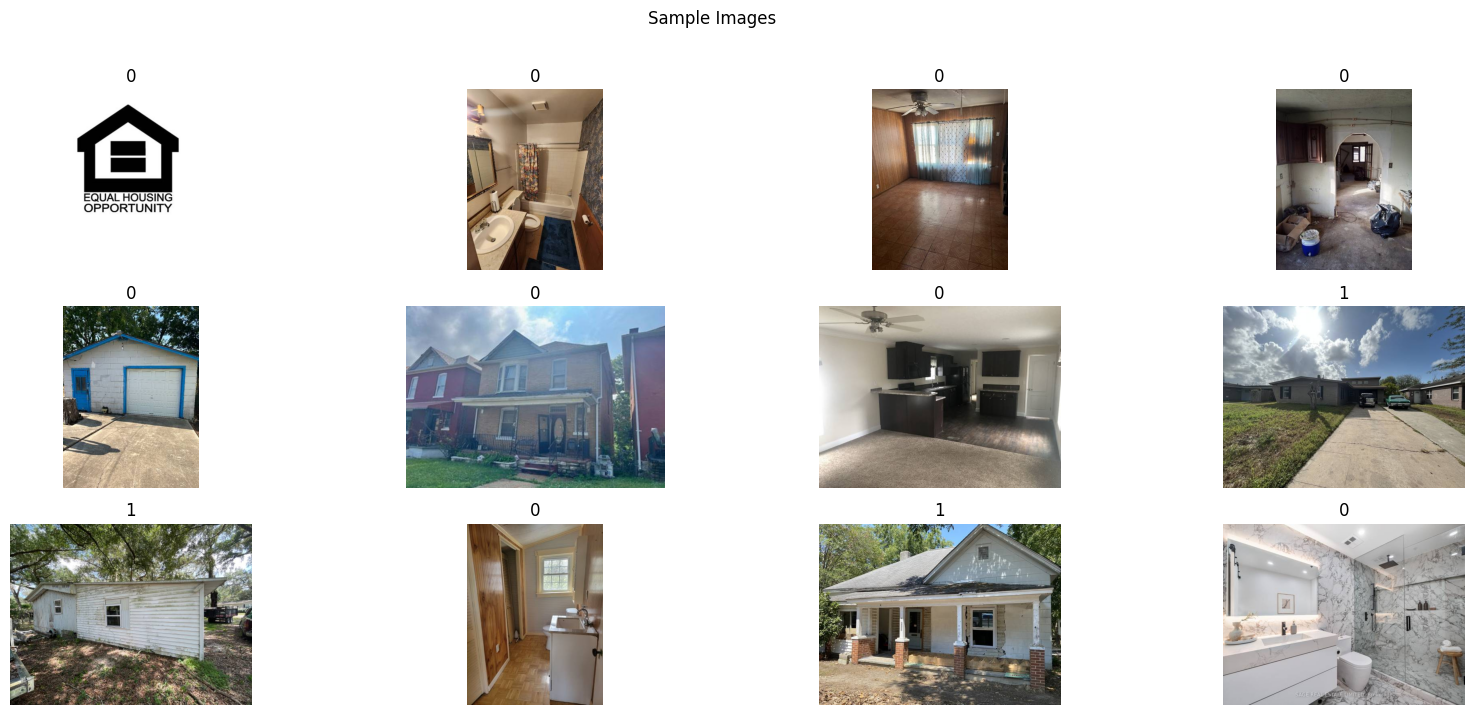

In [19]:
if not RUN_IN_VM:
  # Generate a random sample of index
  import numpy as np

  # Generate a random sample of index
  image_samples = np.random.randint(0,high=len(data_list)-1, size=12)

  fig = plt.figure(figsize=(20,8))
  for i,img_idx in enumerate(image_samples):
      axs = fig.add_subplot(3,4,i+1)
      axs.set_title(data_list[img_idx][0])
      # Read image
      image = plt.imread(data_list[img_idx][1])

      plt.imshow(image);
      plt.axis('off')

  plt.suptitle("Sample Images")
  plt.show()


#### **Generate data_x & data_y**

In [20]:
## to generate data_x & data_y

# Build data x, y
data_x = [itm[1] for itm in data_list]
data_y = [itm[0] for itm in data_list]

# sanity check

print("data_x:",len(data_x))
print("data_y:",len(data_y))
print("data_x:",data_x[:5])
print("data_y:",data_y[:5])


data_x: 3000
data_y: 3000
data_x: ['small_fixer_upper/7666371376/image_3.jpg', 'small_fixer_upper/7666371376/image_11.jpg', 'small_fixer_upper/7666371376/image_7.jpg', 'small_fixer_upper/7666371376/image_20.jpg', 'small_fixer_upper/7666371376/image_23.jpg']
data_y: [0, 0, 0, 0, 0]


## **<font color="#A41034">Build the data pipeline</font>**

#### **Split the Data**

In [21]:
## Train_test_split()
test_percent = 0.10
validation_percent = 0.2

# Split data into train / test
train_validate_x, test_x, train_validate_y, test_y = train_test_split(data_x,
                                                                      data_y,
                                                                      test_size=test_percent)

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x,
                                                            train_validate_y,
                                                            test_size=test_percent)


In [22]:
## sanity check
print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))
print("test_x count:",len(test_x))


train_x count: 2430
validate_x count: 270
test_x count: 300


#### **create TF Data**

In [23]:
## To create TF datasets
def get_dataset(image_width = 224, image_height = 224, num_channels = 3, batch_size = 32):

  # Load Image
  def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=num_channels)
    image = tf.image.resize(image, [image_height,image_width])
    return image, label

  # Normalize pixels
  def normalize(image, label):
    image = image/255
    return image, label

  train_shuffle_buffer_size= len(train_x)
  validation_shuffle_buffer_size= len(validate_x)

  # Create TF Dataset
  train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
  validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_y))
  test_data = tf.data.Dataset.from_tensor_slices((test_x, test_y))

  #############
  # Train data
  #############
  # Apply all data processing logic
  train_data = train_data.cache()\
                        .shuffle(buffer_size=train_shuffle_buffer_size)\
                        .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
                        .batch(batch_size)\
                        .prefetch(tf.data.AUTOTUNE)\

  ##################
  # Validation data
  ##################
  # Apply all data processing logic
  validation_data = validation_data.cache()\
                        .shuffle(buffer_size=validation_shuffle_buffer_size)\
                        .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
                        .batch(batch_size)\
                        .prefetch(tf.data.AUTOTUNE)\

  ############
  # Test data
  ############
  # Apply all data processing logic
  test_data = test_data.cache()\
                        .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
                        .batch(batch_size)\
                        .prefetch(tf.data.AUTOTUNE)\

  return (
      train_data, validation_data, test_data
  )

#### **Download TF Records from Project Bucket**

## **<font color="#A41034">Authenticate login to WandB</font>**

In [24]:
## to relogin as a different user, for example switching to team project authentication
# !wandb login --relogin

In [25]:
## # Login to W&B account
if RUN_IN_VM:
  wandb.login(key=args.wandb_key)
else:
  wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## **<font color="#A41034">Teacher Model (vgg16) with wandb callback and using TF data as input</font>**

In [26]:
## train & save weights into wandb.ai

## transfer learning from keras VGG16 model weights

if RUN_IN_VM:
  ## for running from VM
  model_name = args.model_name
  train_base = args.train_base
  learning_rate = args.lr
  batch_size = args.batch_size
  epochs = args.epochs
else:
  ## for running from local Colab
  model_name = "vgg16_train_base"
  train_base = True
  learning_rate = 0.001           ## TBD
  batch_size = 32
  epochs = 5

## other parameters
img_height = 224
img_width  = 224
img_channel = 3                 ## imagenet is trained on RGB

# Free up memory
K.clear_session()

# Data
train_data, validation_data, test_data = get_dataset(image_width = img_width,
                                                     image_height = img_height,
                                                     num_channels = img_channel,
                                                     batch_size = batch_size)
if USE_VGG16_AS_TEACHER:
  # invoke VGG16
  new_input = Input(shape=(img_height, img_width, img_channel))
  base_model = VGG16(weights='imagenet', input_tensor=new_input, include_top=False)
  base_model.summary()

  # base layers + 3 FC layers
  x = Flatten()(base_model.layers[-1].output)

  # Add a fully connected layer with 1024 units and ReLU activation
  x = Dense(units=1024, activation='relu')(x)
  x = Dense(units=1024, activation='relu')(x)
  x = Dense(units=1024, activation='relu')(x)

  # Add a final output layer with the desired number of classes and sigmoid activation
  output = Dense(units=1, activation='sigmoid')(x)

  # Create the final model by combining the VGG16 base model with the newly added layers
  teacher_model = Model(inputs=base_model.input, outputs=output, name=model_name+'_'+str(train_base))

  # fix all weights in base_model
  for layer in base_model.layers:
      layer.trainable = False

  # Compile the model with appropriate loss, optimizer, and metrics
  teacher_model.compile(optimizer = Adam(),
                      loss = 'binary_crossentropy',
                      metrics = ['acc'])

  # Initialize a W&B run
  wandb.init(
      project = 'rehab-ai-main',
      config = {
        "learning_rate": learning_rate,
        "epochs": epochs,
        "batch_size": batch_size,
        "model_name": teacher_model.name
      },
      name = teacher_model.name
  )

  # Train the model on the training data and validate on the validation data
  start_time = time.time()
  history = teacher_model.fit(train_data,
                            validation_data=validation_data,
                            callbacks=[WandbCallback()],
                            verbose=1,
                            epochs=epochs)

  execution_time = (time.time() - start_time)/60.0
  print("Training execution time (mins)",execution_time)

  # Update W&B
  wandb.config.update({"execution_time": execution_time})

  # Close the W&B run
  wandb.run.finish()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

wandb: Currently logged in as: tonyhua18 (rehab-ai). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/5
76/76 [==============================] - ETA: 0s - loss: 4.8497 - acc: 0.5527

wandb: Adding directory to artifact (/content/wandb/run-20231025_195843-8q7e9uhf/files/model-best)... Done. 2.3s


76/76 [==============================] - 107s 1s/step - loss: 4.8497 - acc: 0.5527 - val_loss: 1.4103 - val_acc: 0.5000
Epoch 2/5
76/76 [==============================] - ETA: 0s - loss: 0.8864 - acc: 0.6527

wandb: Adding directory to artifact (/content/wandb/run-20231025_195843-8q7e9uhf/files/model-best)... Done. 2.6s


76/76 [==============================] - 105s 1s/step - loss: 0.8864 - acc: 0.6527 - val_loss: 0.8819 - val_acc: 0.5889
Epoch 3/5
76/76 [==============================] - 97s 1s/step - loss: 0.6230 - acc: 0.7453 - val_loss: 0.9429 - val_acc: 0.5852
Epoch 4/5
76/76 [==============================] - 98s 1s/step - loss: 0.5532 - acc: 0.7926 - val_loss: 0.8992 - val_acc: 0.5593
Epoch 5/5
76/76 [==============================] - 97s 1s/step - loss: 0.4357 - acc: 0.8259 - val_loss: 0.8989 - val_acc: 0.6000
Training execution time (mins) 8.393645838896434


acc,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▇▇▅█
val_loss,█▁▂▁▁
acc,0.82593
best_epoch,1
best_val_loss,0.88187
epoch,4
loss,0.43568
val_acc,0.6


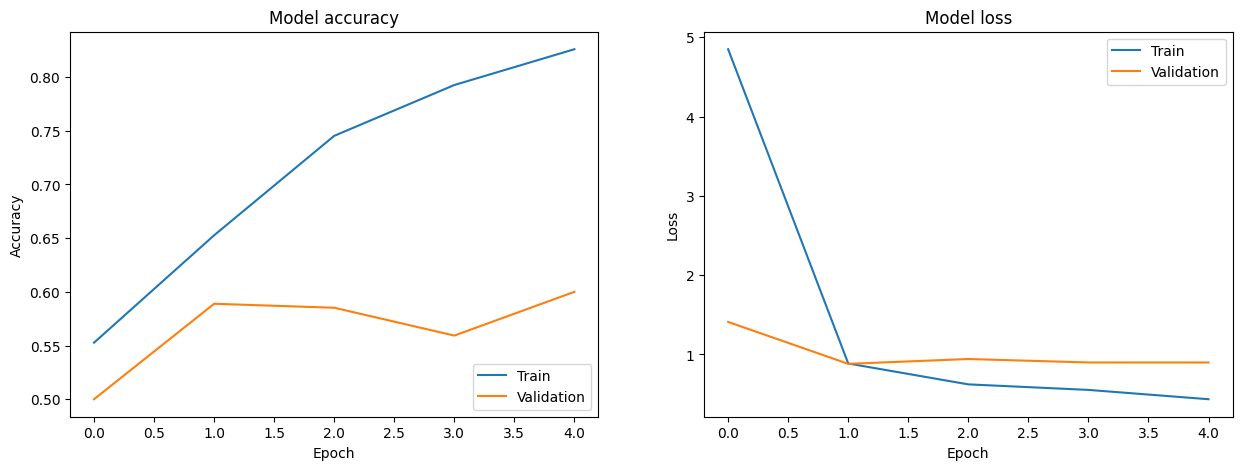

In [27]:
# ploting results loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Plotting accuracy
axs[0].plot(history.history['acc'])
axs[0].plot(history.history['val_acc'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='lower right')
# Plot loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper right')
plt.show()

## **<font color="#A41034">Teacher Model (mobilenet_v2) from tfhub.</font>**

#### **Build Teacher Model**

In [28]:
if USE_MOBILENET_AS_TEACHER:

  def build_teacher_model(image_height, image_width, num_channels, num_classes):

    # Model input
    input_shape = [image_height, image_width, num_channels] # height, width, channels

    # Handle to pretrained model (Use a different model here)
    handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

    # Regularize using L1
    kernel_weight = 0.02
    bias_weight = 0.02

    model = Sequential([
          keras.layers.InputLayer(input_shape=input_shape),
                                  hub.KerasLayer(handle, trainable=False),
          keras.layers.Dense(units=64, activation='relu',
                            kernel_regularizer=keras.regularizers.l1(kernel_weight),
                            bias_regularizer=keras.regularizers.l1(bias_weight)
                            ),
          keras.layers.Dense(units=num_classes-1,
                            kernel_regularizer=keras.regularizers.l1(kernel_weight),
                            bias_regularizer=keras.regularizers.l1(bias_weight)),
    ],name='teacher_model')

    return model

#### **Train Teacher**

In [29]:
############################
# Training Params
############################

if USE_MOBILENET_AS_TEACHER:
  learning_rate = 0.001
  initial_epoch = 0
  epochs = 500

  num_channels = 3
  num_classes = 2

  # Load pre trained model during demos
  LOAD_PREV_TRAINED = False

  # Free up memory
  K.clear_session()

  # Optimizer
  optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
  # Loss
  #loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  loss = keras.losses.BinaryCrossentropy(from_logits=True)

  # Build or Load Model
  if not LOAD_PREV_TRAINED:
    # Build the teacher model
    teacher_model = build_teacher_model(img_height, img_width, num_channels, num_classes)
    print(teacher_model.summary())

    # Compile
    teacher_model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=[keras.metrics.BinaryAccuracy()])
                        # metrics=[keras.metrics.SparseCategoricalAccuracy()])

  else:
    # Load model
    teacher_model = keras.models.load_model("distil_models/teacher_model.hdf5", custom_objects={'KerasLayer':hub.KerasLayer})
    print(teacher_model.summary())


    with open("distil_models/teacher_model_train_history.json") as json_file:
      prev_training_history = json.load(json_file)
    with open("distil_models/teacher_model_model_metrics.json") as json_file:
      model_metrics = json.load(json_file)

    epochs = len(prev_training_history["loss"])
    initial_epoch=epochs
    epochs=epochs+3 # Continue training for a few more epochs


  # Train model
  start_time = time.time()
  training_results = teacher_model.fit(
          train_data,
          validation_data=validation_data,
          epochs=epochs,
          initial_epoch=initial_epoch,
          verbose=1)
  execution_time = (time.time() - start_time)/60.0
  print("Training execution time (mins)",execution_time)

  # Get model training history
  training_history = training_results.history

  if LOAD_PREV_TRAINED:
    # Append previous training history & time
    training_history = append_training_history(training_results.history,
                                              prev_training_history,
                                              metrics=["loss","val_loss","binary_accuracy","val_binary_accuracy"])
    execution_time = model_metrics["execution_time"] + execution_time

  # Evaluate model
  evaluate_model(teacher_model,validation_data, training_history,execution_time,
                      learning_rate, batch_size, epochs, optimizer,
                      save=True,
                      loss_metrics=["loss","val_loss"],
                      acc_metrics=["binary_accuracy","val_binary_accuracy"])
                      #acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

## **<font color="#A41034">Build Student Model</font>**

#### **Student Model**
* 2 conv layers with max pooling and 1 dense layer

In [30]:
def build_student_model(image_height, image_width, num_channels, num_classes, model_name='student'):
  # Model input
  input_shape = [image_height, image_width, num_channels]  # height, width, channels

  model = Sequential(
      [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), padding="same",
                            kernel_initializer=keras.initializers.GlorotUniform(seed=1212)),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same",
                            kernel_initializer=keras.initializers.GlorotUniform(seed=2121)),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        keras.layers.Flatten(),
        # keras.layers.Dense(units=32, kernel_initializer=keras.initializers.GlorotUniform(seed=2323)),
        #keras.layers.Dense(units=num_classes, kernel_initializer=keras.initializers.GlorotUniform(seed=3434))
        keras.layers.Dense(units=num_classes-1, kernel_initializer=keras.initializers.GlorotUniform(seed=3434))
      ],
      name=model_name)

  return model

#### **Train the Student model**
* 2 conv layers with max pooling and 1 dense layer
* for comparison purpose (pre-distillation)

Model: "student_scratch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                               

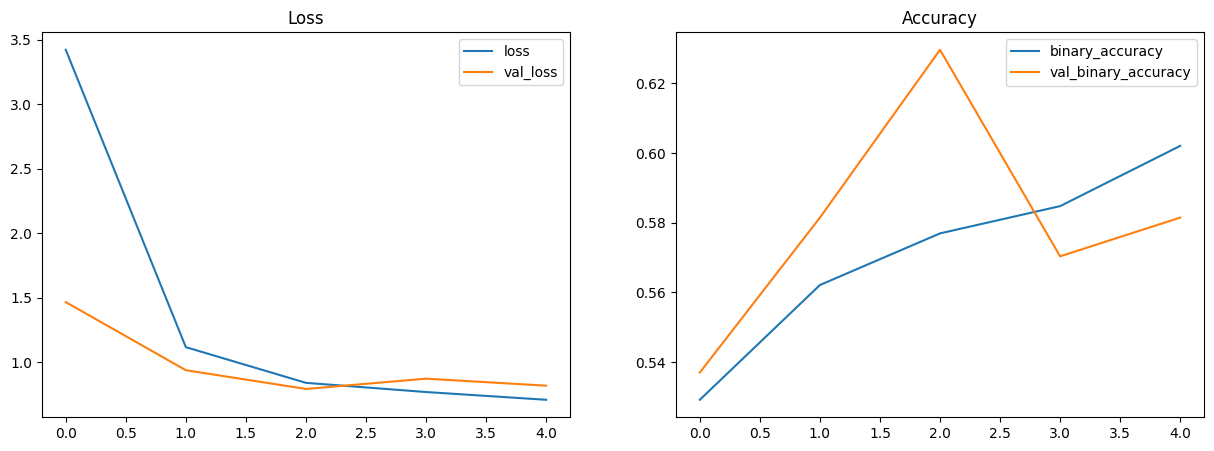

9/9 [==============================] - 0s 9ms/step - loss: 0.8170 - binary_accuracy: 0.5815
{'loss': 0.8170368075370789, 'binary_accuracy': 0.5814814567565918}


[0.8170368075370789, 0.5814814567565918]

In [31]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 5

# Free up memory
K.clear_session()

# Build the model
student_model_scratch = build_student_model(img_height, img_width, img_channel, 2, model_name='student_scratch')
print(student_model_scratch.summary())

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.BinaryCrossentropy(from_logits=True)

# Compile
student_model_scratch.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.BinaryAccuracy()])

# Train teacher model
start_time = time.time()
training_results = student_model_scratch.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
evaluate_model(student_model_scratch,validation_data, training_history,execution_time,
                    learning_rate, batch_size, epochs, optimizer,
                    save=True,
                    loss_metrics=["loss","val_loss"],
                    acc_metrics=["binary_accuracy","val_binary_accuracy"])



## **<font color="#A41034">Build Distiller</font>**

#### **Class definition**
**Distiller(Model)**
* **attribute:** Lambda, temperature
* **method:** compile(), train_step(), test_step()

In [32]:
class Distiller(Model):
    def __init__(self, teacher, student):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, Lambda = 0.1, temperature=3):
      """
      optimizer: Keras optimizer for the student weights
      metrics: Keras metrics for evaluation
      student_loss_fn: Loss function of difference between student predictions and ground-truth
      distillation_loss_fn: Loss function of difference between soft student predictions and soft teacher predictions
      lambda: weight to student_loss_fn and 1-alpha to distillation_loss_fn
      temperature: Temperature for softening probability distributions. Larger temperature gives softer distributions.
      """
      super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn

      #hyper-parameters
      self.Lambda = Lambda
      self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher (professor)
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.Lambda * student_loss + (1 - self.Lambda) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

#### **Knowlege distillation - plain (from teacher to student)**
* matching teacher output (prob) to student output (prob)

Model: "student_distill"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                               

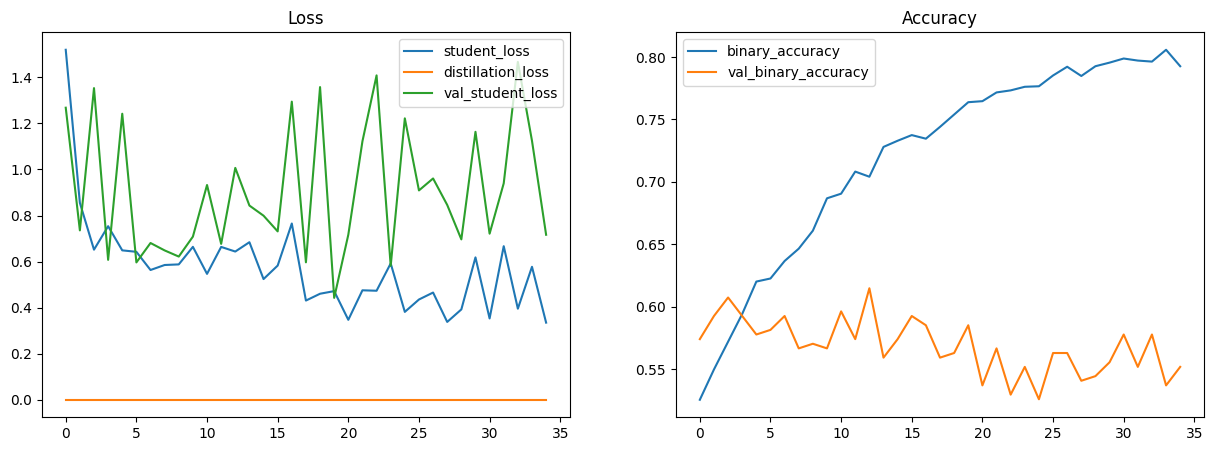

9/9 [==============================] - 0s 9ms/step - binary_accuracy: 0.5519 - student_loss: 1.1120


{'binary_accuracy': 0.5518518686294556, 'student_loss': 0.8420955538749695}


In [33]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 35
Lambda = 0.75
#temperature= 12
temperature= 20

# Free up memory
K.clear_session()

# Build Student model
student_model = build_student_model(img_height, img_width, img_channel, 2, model_name='student_distill')
print(student_model.summary())

# Build the distiller model
distiller_model = Distiller(teacher=teacher_model, student=student_model)

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
student_loss = keras.losses.BinaryCrossentropy(from_logits=True)

#distillation_loss = keras.losses.KLDivergence()
distillation_loss = keras.losses.BinaryCrossentropy(from_logits=False)

# Compile
distiller_model.compile(
    optimizer=optimizer,
    student_loss_fn=student_loss,
    distillation_loss_fn=distillation_loss,
    metrics=[keras.metrics.BinaryAccuracy()],
    Lambda=Lambda,
    temperature=temperature
)

# Distill teacher to student
start_time = time.time()
training_results = distiller_model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
evaluation_results = evaluate_model(distiller_model,validation_data,
               training_history,execution_time,learning_rate, batch_size, epochs, optimizer,
               save=False,
               loss_metrics=["student_loss","distillation_loss","val_student_loss"],
               acc_metrics=["binary_accuracy","val_binary_accuracy"])

# Save student model


save_model(student_model,training_history,execution_time,learning_rate, epochs, optimizer, evaluation_results)

## **<font color="#A41034">Other flavors of Distillation</font>**

#### **Knowlege distillation - online distillation (2  students)**
* no teacher, 2 students, matching output (prob)

#### **Knowlege distillation - online distillation (3  students)**
* no teacher, 3 students, matching output (prob)

#### **Knowlege distillation - Self Distillation**
* 1st iteration: 1 teacher + 1 student, matching output (prob)
* 2nd iteration and onwards: 1 student only

## **<font color="#A41034">Compare All Models</font>**

In [34]:
models_folder = "models" # distil_models / models
models_metrics_list = glob(models_folder+"/*_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    model_metrics["name"] = mm_file.replace(models_folder+"/","").replace("_model_metrics.json","")
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.3f} MB'.format)

view_metrics = view_metrics.sort_values(by=['accuracy'],ascending=False)
view_metrics.head()

,trainable_parameters,execution_time,loss,accuracy,model_size,learning_rate,batch_size,epochs,optimizer,name
0,"4,529",0.16 mins,0.82,58.15%,0.096 MB,0.001,32,5,Adam,student_scratch
1,"4,529",48.71 mins,0.84,55.19%,0.040 MB,0.001,32,35,Adam,student_distill


## **<font color="#A41034">template</font>**

#### **Utils**

Here are some util functions that we will be using for this notebook

#### **Utils**

Here are some util functions that we will be using for this notebook

## **<font color="#A41034">template</font>**

#### **Utils**

Here are some util functions that we will be using for this notebook

#### **Utils**

Here are some util functions that we will be using for this notebook